<a href="https://colab.research.google.com/github/osiris-contreras/Anal-tica-en-Recursos-Humanos/blob/main/modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import sys
import os
path= '/content/drive/MyDrive/codigos/Anal-tica-en-Recursos-Humanos'
os.chdir(path)
sys.path.append(path+'/')

## Visual Studio

In [19]:
import os
import sys

ruta =os.getcwd()
sys.path.append(ruta)

# Modelo

In [20]:
import warnings
warnings.filterwarnings("ignore")



# Importar librerias necesarias
import sqlite3 as sql
import pandas as pd
import a_funciones as fn ### importar modulo de  funciones
from a_funciones import * ### importar toddas las funciones del archivo

from sklearn.linear_model import LogisticRegression ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestClassifier ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt ### gráficos
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables
#import openpyxl

In [21]:
#### conectarse a base de datos preprocesada

con=sql.connect('bases de datos RRHH/datos.db')
cur=con.cursor()

In [22]:
### ver todas las bases de datos ###

cur.execute("select name from sqlite_master where type='table';")
cur.fetchall()


[('completo',),
 ('retiros',),
 ('general',),
 ('employee_survey',),
 ('manager_survey',)]

In [23]:
pd.read_sql(""" select * from completo""", con=con)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,...,JobSatisfaction,WorkLifeBalance,DateSurvey,JobInvolvement,PerformanceRating,SurveyDate,Attrition,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,...,4.0,2.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,...,2.0,4.0,2015-12-31,2,4,2015-12-31,1,2016-10-15,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,...,2.0,1.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
3,38,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,...,4.0,3.0,2015-12-31,2,3,2015-12-31,0,0,NoRetirement,NoRetirement
4,32,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,...,1.0,3.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,42,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,Research Scientist,...,1.0,3.0,2016-12-31,3,3,2016-12-31,0,0,NoRetirement,NoRetirement
8816,29,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,Laboratory Technician,...,4.0,3.0,2016-12-31,2,3,2016-12-31,0,0,NoRetirement,NoRetirement
8817,25,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,Sales Executive,...,3.0,3.0,2016-12-31,3,4,2016-12-31,0,0,NoRetirement,NoRetirement
8818,42,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,Laboratory Technician,...,1.0,3.0,2016-12-31,2,3,2016-12-31,0,0,NoRetirement,NoRetirement


In [24]:
#crear dataframe para el modelado(2015)
df_m = pd.read_sql("""select * from completo
where InfoDate='2015-12-31'
""",con=con)

In [25]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4410 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [26]:
#Eliminación de variables InfoDate y retirementDate, ya que no son relevantes dentro del dataframe (informacion 2015-retiros 2016)
df_m=df_m.drop(columns=['InfoDate','retirementDate'])
df_m.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'DateSurvey', 'JobInvolvement', 'PerformanceRating',
       'SurveyDate', 'Attrition', 'retirementType', 'resignationReason'],
      dtype='object')

In [27]:
#Cambiar variables float a integer
columnas_float=df_m.select_dtypes(include=['float']).columns

df_m[columnas_float]=df_m[columnas_float].astype(int)
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4410 non-null   int64 
 1   BusinessTravel           4410 non-null   object
 2   Department               4410 non-null   object
 3   DistanceFromHome         4410 non-null   int64 
 4   Education                4410 non-null   int64 
 5   EducationField           4410 non-null   object
 6   EmployeeID               4410 non-null   object
 7   Gender                   4410 non-null   object
 8   JobLevel                 4410 non-null   int64 
 9   JobRole                  4410 non-null   object
 10  MaritalStatus            4410 non-null   object
 11  MonthlyIncome            4410 non-null   int64 
 12  NumCompaniesWorked       4410 non-null   int64 
 13  PercentSalaryHike        4410 non-null   int64 
 14  StockOptionLevel         4410 non-null  

In [28]:
#Conversion a Dummyes
list_dummies=['BusinessTravel', 'Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'retirementType',
       'resignationReason']


df_dummies=pd.get_dummies(df_m,columns=list_dummies)



In [29]:
df_dummies.head()

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,MaritalStatus_Married,MaritalStatus_Single,retirementType_Fired,retirementType_NoRetirement,retirementType_Resignation,resignationReason_Fired,resignationReason_NoRetirement,resignationReason_Others,resignationReason_Salary,resignationReason_Stress
0,51,6,2,1,1,131160,1,11,0,1,...,True,False,False,True,False,False,True,False,False,False
1,31,10,1,2,1,41890,0,23,1,6,...,False,True,False,False,True,False,False,True,False,False
2,32,17,4,3,4,193280,1,15,3,5,...,True,False,False,True,False,False,True,False,False,False
3,38,2,5,4,3,83210,3,11,3,13,...,True,False,False,True,False,False,True,False,False,False
4,32,10,1,5,1,23420,4,12,2,9,...,False,True,False,True,False,False,True,False,False,False


In [30]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 56 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Age                                4410 non-null   int64 
 1   DistanceFromHome                   4410 non-null   int64 
 2   Education                          4410 non-null   int64 
 3   EmployeeID                         4410 non-null   object
 4   JobLevel                           4410 non-null   int64 
 5   MonthlyIncome                      4410 non-null   int64 
 6   NumCompaniesWorked                 4410 non-null   int64 
 7   PercentSalaryHike                  4410 non-null   int64 
 8   StockOptionLevel                   4410 non-null   int64 
 9   TotalWorkingYears                  4410 non-null   int64 
 10  TrainingTimesLastYear              4410 non-null   int64 
 11  YearsAtCompany                     4410 non-null   int64 
 12  YearsS

In [31]:
#Eliminacion de variables categoricas(fecha) y variables resignationReason ya que se presentan una alta correlación con la variable objetivo Attrition lo cual sesga el desempeño de los modelos.
df_dummies=df_dummies.drop(columns=['DateSurvey','SurveyDate','resignationReason_Fired', 'resignationReason_NoRetirement',
       'resignationReason_Others', 'resignationReason_Salary',
       'resignationReason_Stress', 'retirementType_Fired',
       'retirementType_NoRetirement', 'retirementType_Resignation' ])


# Selección de variables

In [32]:
y=df_dummies.Attrition
X1= df_dummies.loc[:,~df_dummies.columns.isin(['Attrition',
                                               'EmployeeID'])]

Escalada de variables numéricas

In [33]:
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

# Definición de modelos


In [34]:
m_lreg = LogisticRegression()
m_rtree = tree.DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

modelos=list([m_lreg,m_rtree, m_rf, m_gbt])

Selección de variables desde las funciones

In [35]:
var_names=fn.sel_variables(modelos,X,y,threshold="2.5*mean")
var_names.shape


(11,)

In [36]:
X2=X[var_names]
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   EnvironmentSatisfaction  4410 non-null   float64
 3   JobSatisfaction          4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   PercentSalaryHike        4410 non-null   float64
 7   TotalWorkingYears        4410 non-null   float64
 8   YearsAtCompany           4410 non-null   float64
 9   YearsSinceLastPromotion  4410 non-null   float64
 10  YearsWithCurrManager     4410 non-null   float64
dtypes: float64(11)
memory usage: 379.1 KB


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   float64
 1   DistanceFromHome                   4410 non-null   float64
 2   Education                          4410 non-null   float64
 3   JobLevel                           4410 non-null   float64
 4   MonthlyIncome                      4410 non-null   float64
 5   NumCompaniesWorked                 4410 non-null   float64
 6   PercentSalaryHike                  4410 non-null   float64
 7   StockOptionLevel                   4410 non-null   float64
 8   TotalWorkingYears                  4410 non-null   float64
 9   TrainingTimesLastYear              4410 non-null   float64
 10  YearsAtCompany                     4410 non-null   float64
 11  YearsSinceLastPromotion            4410 non-null   float

#Validación de modelo utilizando K fold cross validation

In [40]:
f1_full=fn.medir_modelos(modelos,"f1",X,y,5) ## base con todas las variables
f1_varsel=fn.medir_modelos(modelos,"f1",X2,y,5) ### base con variables seleccionadas


F1=pd.concat([f1_full,f1_varsel],axis=1)
F1.columns=['rl', 'dt', 'rf', 'gb',
       'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
F1



,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.219355,0.992248,1.000000,0.577540,0.045113,0.996139,1.000000,0.491620
1,0.230769,0.693467,0.761905,0.428571,0.030075,0.680203,0.773585,0.345679
2,0.219355,0.996139,1.000000,0.609626,0.044776,0.996169,1.000000,0.502793
3,0.220779,0.700000,0.767773,0.431138,0.045113,0.700000,0.761905,0.352201
4,0.208092,0.806250,0.809969,0.507463,0.044118,0.809969,0.809969,0.430769


,0
rl,0.219670
dt,0.837621
rf,0.867929
gb,0.510868
rl_Sel,0.041839
dt_sel,0.836496
rf_sel,0.869092
gb_Sel,0.424613


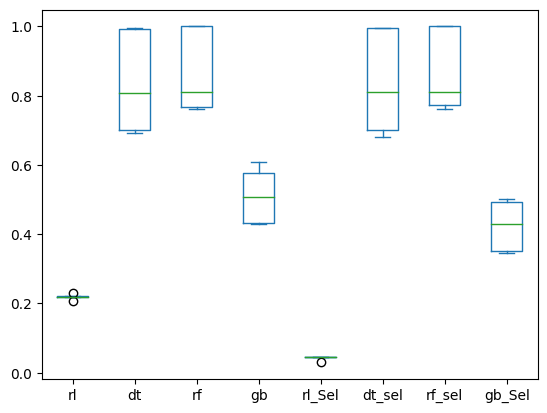

In [50]:
F1_2=F1[ ['rl','dt', 'rf', 'gb','rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']]
F1_2.plot(kind='box') ### gráfico para modelos sel y todas las variables

F1.mean() ### medias de mape

#Evaluación_accuracy

In [49]:
accuracy_full=fn.medir_modelos(modelos,"accuracy",X,y,5) ## base con todas las variables
accuracy_varsel=fn.medir_modelos(modelos,"accuracy",X2,y,5) ### base con variables seleccionadas


accuracy=pd.concat([accuracy_full,accuracy_varsel],axis=1)
accuracy.columns=['rl', 'dt', 'rf', 'gb',
       'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
accuracy

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.862812,0.996599,1.000000,0.910431,0.856009,0.998866,1.000000,0.896825
1,0.863946,0.930839,0.942177,0.891156,0.853741,0.928571,0.942177,0.879819
2,0.862812,1.000000,1.000000,0.917234,0.854875,0.998866,1.000000,0.899093
3,0.863946,0.930839,0.941043,0.892290,0.856009,0.930839,0.948980,0.883220
4,0.844671,0.929705,0.930839,0.893424,0.852608,0.930839,0.930839,0.874150


,0
rl,0.859637
dt,0.957596
rf,0.962812
gb,0.900907
rl_Sel,0.854649
dt_sel,0.957596
rf_sel,0.964399
gb_Sel,0.886621


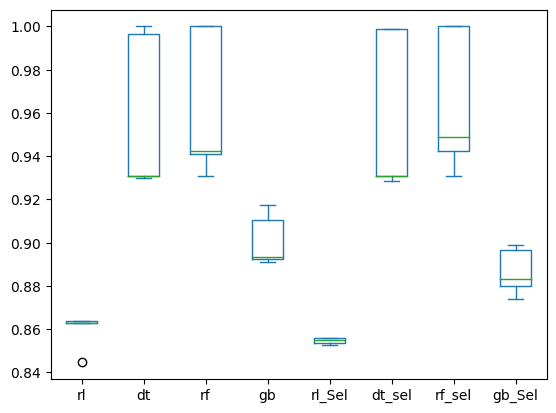

In [52]:
accuracy_2=accuracy[ ['rl','dt', 'rf', 'gb','rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']]
accuracy_2.plot(kind='box') ### gráfico para modelos sel y todas las variables
accuracy.mean() ### medias de mape